In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision   
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time
import torch.optim as optim
import os
import gdown
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
!pwd

Sat Apr 10 05:38:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1-kQKJdOm5eU4ZGQYkUYQnmVEuLs3lkUt'
gdown.download(url, '/content/data.tar.gz', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1-kQKJdOm5eU4ZGQYkUYQnmVEuLs3lkUt
To: /content/data.tar.gz
4.05GB [00:46, 87.3MB/s]


'/content/data.tar.gz'

In [ ]:
!tar -xvf /content/data.tar.gz

Streaming output truncated to the last 5000 lines.
knnw-720p/frame_168853.jpeg
knnw-720p/frame_114577.jpeg
knnw-720p/frame_8202.jpeg
knnw-720p/frame_95151.jpeg
knnw-720p/frame_154107.jpeg
knnw-720p/frame_122883.jpeg
knnw-720p/frame_57178.jpeg
knnw-720p/frame_30705.jpeg
knnw-720p/frame_84239.jpeg
knnw-720p/frame_165633.jpeg
knnw-720p/frame_68090.jpeg
knnw-720p/frame_134649.jpeg
knnw-720p/frame_158030.jpeg
knnw-720p/frame_57920.jpeg
knnw-720p/frame_111357.jpeg
knnw-720p/frame_142341.jpeg
knnw-720p/frame_41489.jpeg
knnw-720p/frame_3297.jpeg
knnw-720p/frame_81019.jpeg
knnw-720p/frame_138572.jpeg
knnw-720p/frame_147118.jpeg
knnw-720p/frame_178102.jpeg
knnw-720p/frame_115280.jpeg
knnw-720p/frame_72473.jpeg
knnw-720p/frame_131429.jpeg
knnw-720p/frame_162413.jpeg
knnw-720p/frame_54700.jpeg
knnw-720p/frame_65484.jpeg
knnw-720p/frame_158644.jpeg
knnw-720p/frame_135352.jpeg
knnw-720p/frame_142955.jpeg
knnw-720p/frame_112060.jpeg
knnw-720p/frame_11950.jpeg
knnw-720p/frame_42192.jpeg
knnw-720p/fram

In [ ]:
!mkdir /content/data
!mv /content/knnw-720p/ /content/data/knnw-720p/

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda, device, torch.cuda.device_count())

True cuda 1


## Model

In [ ]:
# Architecture follows the design in https://github.com/AntixK/PyTorch-VAE
class MyBetaVAE(nn.Module):
    def __init__(self, in_channels, z_dim, beta): # image should have size 64*64
        super(MyBetaVAE, self).__init__()
        self.z_dim = z_dim
        self.beta = beta

        hidden_dims = [in_channels, 32, 64, 128, 256, 512]
        self.hidden_dims = hidden_dims

        # encoder
        encoder_layers = []
        for i in range(len(hidden_dims)-1):
            encoder_layers.append(nn.Sequential(
                                        nn.Conv2d(hidden_dims[i], hidden_dims[i+1], kernel_size=3, stride=2, padding=1),
                                        nn.BatchNorm2d(hidden_dims[i+1]),
                                        nn.LeakyReLU()
                                  ))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.mu = nn.Linear(hidden_dims[-1] * 4, z_dim)
        self.logvar = nn.Linear(hidden_dims[-1] * 4, z_dim)

        # decoder
        self.decoder_in = nn.Linear(z_dim, hidden_dims[-1] * 4)

        decoder_layers = []
        for i in range(len(hidden_dims)-1, 0, -1):
            decoder_layers.append(nn.Sequential(
                                      nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i] if i == 1 else hidden_dims[i-1], kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.BatchNorm2d(hidden_dims[i] if i == 1 else hidden_dims[i-1]),
                                      nn.LeakyReLU()
                                  ))
        
        self.decoder = nn.Sequential(*decoder_layers,
                                     nn.Conv2d(hidden_dims[1], hidden_dims[0], kernel_size=3, padding=1),
                                     nn.Tanh())
    
    def encode(self, x):
        out = self.encoder(x)
        out = torch.flatten(out, start_dim=1)
        mu = self.mu(out)
        logvar = self.logvar(out)
        self.mu_value = mu
        self.logvar_value = logvar
        self.x = x
        return mu, logvar
    
    def decode(self, x):
        out = self.decoder_in(x).view(-1, self.hidden_dims[-1], 2, 2)
        out = self.decoder(out)
        return out
    
    def reparam(self, mu, logvar):
        std = torch.exp(logvar / 2)
        epsilon = torch.autograd.Variable(torch.randn_like(std))
        return std * epsilon + mu


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        out = self.decode(z)
        self.x_cons = out
        return out, z
    
    def loss(self):
        reconstruction_loss = F.mse_loss(self.x_cons, self.x)
        kl_div = torch.mean(torch.sum(-0.5 * (1 + self.logvar_value - self.mu_value ** 2 - self.logvar_value.exp()), dim=1), dim=0)
        return reconstruction_loss + self.beta * kl_div, reconstruction_loss, kl_div

In [ ]:
in_channels, z_dim, beta = 3, 128, 4
model = MyBetaVAE(in_channels, z_dim, beta)
model = model.to(device)
print(model, next(model.parameters()).is_cuda)

MyBetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seq

In [ ]:
learningRate = 0.0005
weightDecay = 0.0
epochs = 10
gamma = 0.95
torch.manual_seed(42)
np.random.seed(11785)

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

## DataLoader

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
])

def get_dataloaders(path):
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transforms)
    shuffle_dataset = True
    use_proportion = 1.0
    validation_split = .2
    batch_size = 256
    random_seed= 42
    # Creating data indices for training and validation splits:
    indices = list(range(len(dataset)))
    use_length = int(len(dataset) * use_proportion)
    split = int(np.floor((1 - validation_split) * len(dataset)) * use_proportion)
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[:split]
    val_indices = indices[split:use_length]
    print(len(dataset), use_length, split)

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True,sampler=train_sampler)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True,sampler=val_sampler)

    return train_dataloader, val_dataloader

train_loader, val_loader = get_dataloaders('/content/data')

191881 191881 153504


## Train

In [ ]:
def train(model, train_loader, val_loader, epochs):
    model.train()
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        avg_loss = 0.0
        for batch_num, (x, y) in enumerate(train_loader):
            x = x.to(device)
            
            optimizer.zero_grad()

            recons_x, z = model(x)
            loss, mse, kld = model.loss()

            with open('/content/drive/MyDrive/train_loss.txt', 'a') as ft:
                ft.write('%f\n' % loss.item())
            with open('/content/drive/MyDrive/train_mse_loss.txt', 'a') as ft1:
                ft1.write('%f\n' % mse.item())
            with open('/content/drive/MyDrive/train_kld_loss.txt', 'a') as ft2:
                ft2.write('%f\n' % kld.item())
            
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            

            if batch_num % 200 == 199:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/200))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del x
            del recons_x
            del z
            del loss
            del mse
            del kld
            torch.cuda.empty_cache()

        end_time = time.time()
        print(end_time - start_time)
        val_loss = val(model, val_loader)
        # scheduler.step(val_loss)
        scheduler.step()
        if val_loss < best_loss:
            best_loss = val_loss
            checkpoint = {"model": model.state_dict(), 
                          "optimizer": optimizer.state_dict(),
                          "scheduler": scheduler.state_dict()}
            torch.save(checkpoint, '/content/drive/MyDrive/checkpoint.pt')
        print('Val Loss: {:.4f}'.format(val_loss))
        print('lr: ', optimizer.param_groups[0]['lr'])


def val(model, loader):
    model.eval()
    avg_loss = 0.0
    avg_mse = 0.0
    avg_kld = 0.0

    with torch.no_grad():
        for batch_num, (x, y) in enumerate(loader):
            x = x.to(device)
            _, _ = model(x)
            loss, mse, kld = model.loss()

            avg_loss += loss.item()  
            avg_mse += mse.item()
            avg_kld += kld.item()
            
            torch.cuda.empty_cache()
            del x
            del loss
            del mse
            del kld
            torch.cuda.empty_cache()

    model.train()
    avg_loss = avg_loss / len(loader)
    avg_mse = avg_mse / len(loader)
    avg_kld = avg_kld / len(loader)
    with open('/content/drive/MyDrive/val_loss.txt', 'a') as fv:
        fv.write('%f\n' % avg_loss)
    with open('/content/drive/MyDrive/val_mse_loss.txt', 'a') as fv1:
        fv1.write('%f\n' % avg_mse)
    with open('/content/drive/MyDrive/val_kld_loss.txt', 'a') as fv2:
        fv2.write('%f\n' % avg_kld)

    return avg_loss

In [ ]:
train(model, train_loader, val_loader, epochs)

Epoch: 1	Batch: 200	Avg-Loss: 2.0095
Epoch: 1	Batch: 400	Avg-Loss: 0.1209
2072.6003692150116
Val Loss: 0.0912
lr:  0.000475
Epoch: 2	Batch: 200	Avg-Loss: 0.0876
Epoch: 2	Batch: 400	Avg-Loss: 0.0849
2025.0908029079437
Val Loss: 0.0849
lr:  0.00045125
Epoch: 3	Batch: 200	Avg-Loss: 0.0801
Epoch: 3	Batch: 400	Avg-Loss: 0.0833
1962.7393729686737
Val Loss: 0.0807
lr:  0.0004286875
Epoch: 4	Batch: 200	Avg-Loss: 0.0769
Epoch: 4	Batch: 400	Avg-Loss: 0.0768
1998.8757739067078
Val Loss: 0.0759
lr:  0.00040725312499999993
Epoch: 5	Batch: 200	Avg-Loss: 0.0760
Epoch: 5	Batch: 400	Avg-Loss: 0.0768
1962.824117898941
Val Loss: 0.0821
lr:  0.0003868904687499999
Epoch: 6	Batch: 200	Avg-Loss: 0.0733
Epoch: 6	Batch: 400	Avg-Loss: 0.0757
1981.4679055213928
Val Loss: 0.0748
lr:  0.0003675459453124999
Epoch: 7	Batch: 200	Avg-Loss: 0.0731
Epoch: 7	Batch: 400	Avg-Loss: 0.0827
2034.5530319213867
Val Loss: 0.0708
lr:  0.00034916864804687486
Epoch: 8	Batch: 200	Avg-Loss: 0.0731
Epoch: 8	Batch: 400	Avg-Loss: 0.0724

In [ ]:
from PIL import Image
img = Image.open('/content/data/knnw-720p/frame_30333.jpeg')

In [ ]:
transforms(img).shape

torch.Size([3, 142, 189])

## Plot Loss Graphs

In [7]:
path = '/content/drive/MyDrive/Courses/11785 Project Group/baseline_loss'

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
# train_kld_loss = pd.read_csv(path+'/train_kld_loss.txt', sep=" ", header=None)
# train_kld_loss['global_batch_num'] = train_kld_loss.index
# train_kld_loss.columns = ["kld_loss", "global_batch_num"]
# sns.lineplot(data=train_kld_loss, x="global_batch_num", y="kld_loss").set_title("Train KLD Loss Beta=4")
# plt.show()

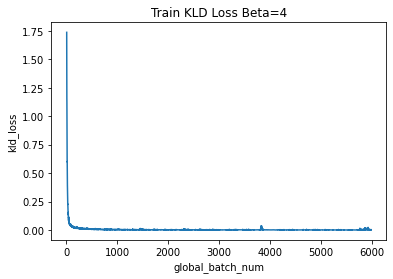

In [29]:
train_kld_loss = pd.read_csv(path+'/train_kld_loss.txt', sep=" ", header=None)
train_kld_loss['global_batch_num'] = train_kld_loss.index
train_kld_loss.columns = ["kld_loss", "global_batch_num"]
sns.lineplot(data=train_kld_loss[train_kld_loss['global_batch_num'] >= 10], x="global_batch_num", y="kld_loss").set_title("Train KLD Loss Beta=4")
plt.show()

In [35]:
# train_mse_loss = pd.read_csv(path+'/train_mse_loss.txt', sep=" ", header=None)
# train_mse_loss['global_batch_num'] = train_mse_loss.index
# train_mse_loss.columns = ["mse_loss", "global_batch_num"]
# sns.lineplot(data=train_mse_loss, x="global_batch_num", y="mse_loss").set_title("Train MSE Loss Beta=4")
# plt.show()

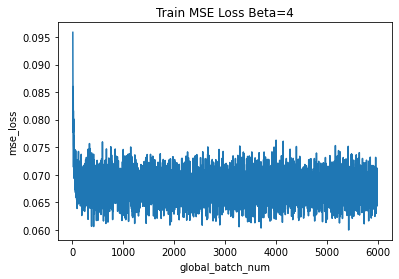

In [28]:
train_mse_loss = pd.read_csv(path+'/train_mse_loss.txt', sep=" ", header=None)
train_mse_loss['global_batch_num'] = train_mse_loss.index
train_mse_loss.columns = ["mse_loss", "global_batch_num"]
sns.lineplot(data=train_mse_loss[train_mse_loss['global_batch_num'] >= 10], x="global_batch_num", y="mse_loss").set_title("Train MSE Loss Beta=4")
plt.show()

In [37]:
# train_loss = pd.read_csv(path+'/train_loss.txt', sep=" ", header=None)
# train_loss['global_batch_num'] = train_loss.index
# train_loss.columns = ["total_loss", "global_batch_num"]
# sns.lineplot(data=train_loss, x="global_batch_num", y="total_loss").set_title("Train TOTAL Loss Beta=4")
# plt.show()

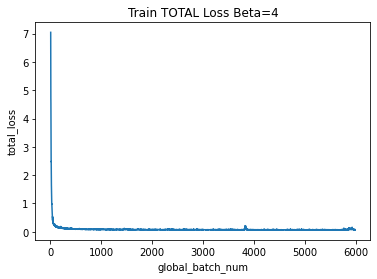

In [30]:
train_loss = pd.read_csv(path+'/train_loss.txt', sep=" ", header=None)
train_loss['global_batch_num'] = train_loss.index
train_loss.columns = ["total_loss", "global_batch_num"]
sns.lineplot(data=train_loss[train_loss['global_batch_num'] >= 10], x="global_batch_num", y="total_loss").set_title("Train TOTAL Loss Beta=4")
plt.show()

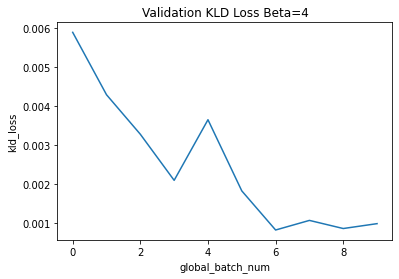

In [31]:
val_kld_loss = pd.read_csv(path+'/val_kld_loss.txt', sep=" ", header=None)
val_kld_loss['global_batch_num'] = val_kld_loss.index
val_kld_loss.columns = ["kld_loss", "global_batch_num"]
sns.lineplot(data=val_kld_loss, x="global_batch_num", y="kld_loss").set_title("Validation KLD Loss Beta=4")
plt.show()

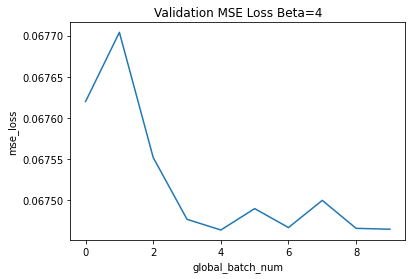

In [33]:
val_mse_loss = pd.read_csv(path+'/val_mse_loss.txt', sep=" ", header=None)
val_mse_loss['global_batch_num'] = val_mse_loss.index
val_mse_loss.columns = ["mse_loss", "global_batch_num"]
sns.lineplot(data=val_mse_loss, x="global_batch_num", y="mse_loss").set_title("Validation MSE Loss Beta=4")
plt.show()

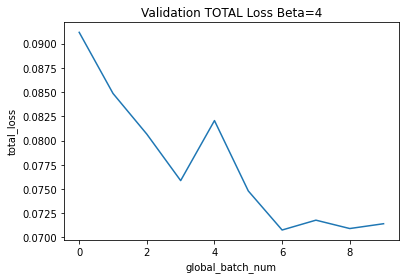

In [34]:
val_loss = pd.read_csv(path+'/val_loss.txt', sep=" ", header=None)
val_loss['global_batch_num'] = val_loss.index
val_loss.columns = ["total_loss", "global_batch_num"]
sns.lineplot(data=val_loss, x="global_batch_num", y="total_loss").set_title("Validation TOTAL Loss Beta=4")
plt.show()